# 1.Introduction

This report focuses on the modeling of a copper beam using the finite difference method and explores the behavior of the beam under various boundary conditions. In addition to studying the steady-state biharmonic equation, we also consider the non-stationary or time-dependent version of the biharmonic equation. This comprehensive analysis allows us to gain insights into the dynamic response of the beam and understand the significance of different boundary conditions, particularly in relation to moments and displacements.

The biharmonic equation, as mentioned earlier, describes the bending behavior of thin plates or beams. In its non-stationary form, the biharmonic equation can be expressed as:

$$
\frac{\partial^4u}{\partial x ^4} = a^2 \frac{\partial^2 u}{\partial t^2}
$$

where u(x, t) represents the displacement of the beam at position x and time t, and α² represents the square of a characteristic frequency. This equation accounts for both spatial and temporal variations in the beam's bending behavior.

In our case, we are interested in the stationary or time-independent solution of the biharmonic equation. This implies that the deflection does not change with time, and the equation simplifies to a static problem. 

$$
\frac{\partial^4u}{\partial x ^4} = 0
$$

We seek to solve this equation numerically using the finite difference method, which discretises the domain into dx intervals. The boundary conditions specify the vibrations and the bendong moments at the ends of the beam. In this example, the beam is blocked at the ends so the boundarys are all 0. 

The bending moments at x=0 and x=L are :

$$
\frac{\partial^2u(x)}{\partial x ^2} = 0 
$$

The exterieur forces at x=0 and x=L are :

$$
u(x) = 0
$$

By solving the Biharmonic equation with these boundary conditions, we can determine the profile along the copper beam.


In [28]:
using BoundaryValueDiffEq
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools

# 2.Source Fonction 


In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the Biharmonic equation, this force is actually a constraint peak of magnitude A, width σ and located at position X0 on the beam. In this example, the constraint peak is located 60 cm along the beam, with a narrow width.




In [29]:
function source_function(x)
    X0 = 60.0
    σ = 0.8
    A = 10.
    return  A .* exp.(.-((x .- X0).^2)./σ^2)
end

source_function (generic function with 1 method)

In [30]:
function source(N)
#Parameter
    l = 80.
    dx = l/N
#Mesh
    X_vect = Vector(0:dx:l)
# Function source
    f = source_function(X_vect)
    return f
end

source (generic function with 1 method)

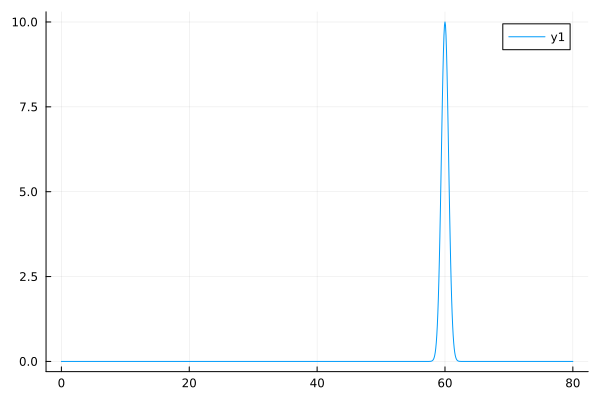

In [31]:
N = 1000
l = 80.
dx = l/N
plot(Vector(0:dx:l),source(N))

# 3.Finite difference modelling.


The 1D time-independent Biharmonic equation is a mathematical model used to describe the distribution of constraints in a one-dimensional medium over time.

$$\frac{\partial^4{u}}{\partial{x}^4} = 0$$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
    \frac{\alpha(U_{i+2} -4U_{i+1} + 6U{i} - 4U_{i-1} + U_{i-2})}{dx^4} = 0
$$
With the boudarys conditions :

$$
    U_0 = 0 
$$
$$
    U_1 = 0
$$
$$
    U_{N-1} = 0
$$
$$
    U_N = 0
$$
This leads to a system of linear equations Au = b, where A is a tridiagonal matrix that represents the coefficients of the finite difference scheme, x is the vector containing the unknown temperature values at each discretized point. 
$$
A = \frac{\kappa}{dx^2} \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
0 & 1 & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
1 & -4 & 6 & -4 & 1 & 0 &\dots & \dots & 0 \\
0 & 1 & -4 & 6 & -4 & 1 & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 & 0 \\
 0 & \dots  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 \\
0&\dots & \dots & \dots & \dots & \dots & 0 & 1 & 0 \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

The vector b is is containing the known boundary conditions, so for this example the vector will be : 
$$
    \mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0\end{bmatrix}
$$

The constraint source must be added to the linear system to get the real case. 

$$
    \mathbf{S} = \begin{bmatrix} f(0) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(L)\end{bmatrix}
$$

So the linear system that we trying to solve is :

$$
   \fbox{ Au = b+S}
$$

Firstly, we will create the matrix A with the data used for a copper beam. We'll use σ is the stress (force per unit area) applied to the material,E is the Young's modulus, a material property representing its stiffness and ε is the strain, which is the ratio of deformation to the original dimension.
$$
    \epsilon = \frac{\sigma}{E }
$$


In [32]:
function matrix(n)
#Parameter
    l = 80.#length 
    σ = 10 #contrainte GPa
    E = 128 #cYoung module 
    ϵ = σ/E #Hooke 
    dx = l/n
    #α = ϵ / dx^4
    α = 1 / dx^4

    

# Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

# Coefficient that change in the  matrix (TRIED SOMETHING THAT WORK BETTER)
    A[1,2] = 0
    A[1,1]= 1
    A[1,3] = 0
    A[2,1] = 0
    A[2,2] = 1
    A[2,3] = 0
    A[2,4] = 0
    A[n-1, n-3] = 0
    A[n-1,n-2] = 0
    A[n-1,n-1] = 1
    A[n-1,n] = 0
    A[n,n-2] = 0
    A[n,n-1] = 0
    A[n,n]= 1

#time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

matrix (generic function with 1 method)

In [33]:
function biharmonic(N)
    #Parameter of the beam
        l= 80 #length
        dx = l/ N  

    # Build of the matrix A
        A = matrix(N+1)

    # Vector B from Au = B (Boundary)
        b = zeros(N+1)
        b[1] = 0 #encastrement 
        b[2] = 0     #Not sure about this
        b[end-1] = 0 #Not sure about this 
        b[end] = 0 #encastrement

    # Vector S for the source power
        X_vect = Vector(0:dx:l)
        S = source_function(X_vect) 
        S[1] = 0                       #Not sure about this 
        S[end] = 0                     #Not sure about this

    # Solving of the Linear System
        u = A \ (b+S) 
        return u
end

biharmonic (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 1000x1000 matrix, the resolution time is fairly short.

In [34]:
@btime biharmonic(1000)

  698.047 μs (151 allocations: 1.64 MiB)


1001-element Vector{Float64}:
  0.0
  0.0
  0.33757439703739817
  1.0115948453914994
  2.0209329993416083
  3.364460513167028
  5.04104904114706
  7.049570237561004
  9.388895756688152
 12.057897252807793
  ⋮
 27.994280957621296
 21.038429257751265
 15.057962712347518
 10.058983969915127
  6.047595678959143
  3.029900487984604
  1.0120010454965451
  5.408517947077699e-269
  0.0

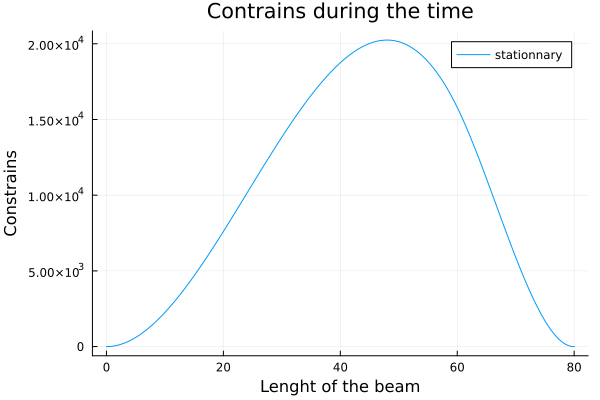

In [35]:
title = "Contrains during the time"
X = Vector(0:dx:l)
U = biharmonic(N)
plot(X, U[:,1], label = "stationnary ", xlabel = "Lenght of the beam", ylabel = "Constrains", title = title)


# 4.Using BoundaryValueDiffEq from julia


Modeling with BoundaryValueDiffEq involves solving boundary value problems (BVPs) for differential equations in Julia. The BoundaryValueDiffEq package provides a comprehensive set of tools for solving BVPs, including a wide range of solvers and utilities.

To use BoundaryValueDiffEq, we define our BVP by specifying the differential equation, boundary conditions, and the domain or spatial range. The differential equation is typically defined as a function that calculates the derivatives of the dependent variables with respect to the independent variable(s). The boundary conditions define the values or relationships at the boundaries of the domain.

Once the BVP is defined, we create a BVProblem object, which encapsulates the differential equation, boundary conditions, and domain information. We can then use the solve() function to solve the BVP and obtain the solution.

BoundaryValueDiffEq supports various numerical methods for solving BVPs, including shooting methods, finite difference methods, and collocation methods. The choice of solver depends on the specific problem characteristics and requirements.

I will divide the programme into three parts : 

The first of which will explain the problem of diffusion. The problem can be explained in the same way as the Biharmonic equation.


   $$ \frac{\partial^4{u}}{\partial{x}^4} = - f $$

   $$ \frac{\partial{u}}{\partial{x}} = U_2   $$

   $$ \frac{\partial^2{u}}{\partial{x}^2} = U_3 $$  

   $$ \frac{\partial^3{u}}{\partial{x}^3} = U_4 $$ 

   $$ \frac{\partial^4{u}}{\partial{x}^4} = 0 - f $$


The second part is the boundarys are explicited. Indeed, there are two boudarys conditions.


   $$ U(0) = 0 $$
   
   $$ U(L) = 0 $$
   
   $$\frac{\partial^2{U(0)}}{\partial{x}^2} = 0 $$ 
   
   $$\frac{\partial^2{U(L)}}{\partial{x}^2} = 0 $$ 
   
   


The last part is the resolution of the diffusion function and the boundarys function. As before, the parameters are those of an 80cm copper beam. With this programme, my result (sol1) is an N x 2 matrix, but to plot the solution, I only need the first term of each line. So I create a loop to obtain the solution vector sol2.



In [36]:
# define diffusion equation 
function diffusion!(du, u, p, x)
    # u[1]: concentration 
    # u[2]: fluc 
    # d/dx(concentration)  = flux 
    du[1] = u[2]
    # d/dx(flux)  = sourceFct
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0 + source_function(x)
end

diffusion! (generic function with 1 method)

In [37]:
# define boundary conditions 
function boundaries!(residual, u, p, x)
    # residual boundary condition in the left end-point 
    residual[1] = u[1][1] - 0.
    residual[2] = u[2][1] - 0.
    residual[end-1] = u[end-1][1] - 0.
    residual[end] = u[end][1] - 0
end

boundaries! (generic function with 1 method)

In [38]:
function set_boundarys(N)  
# define spatial range 
    xspan = (0.0, 80.)
    σ = 10 #contrainte GPa
    E = 128 #cYoung module 
    ϵ = σ/E #Hooke 
    l = 80.
    dx = l/N
    p = [ϵ]; 

 
    
#set the boundary value problem to solve
bvp1 = BVProblem(diffusion!, boundaries!, [0., 0.,0.,0.], xspan,p)

# set the boundary value problem  
sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
sol2 = zeros(length(sol1))

for i in 1:length(sol1)
    sol2[i] = sol1[i][1]  
end
return sol2
    
end


set_boundarys (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 100 points, the resolution time is long(60 sec). So it is important to note that the finite difference mode is shorter.

In [39]:
@btime set_boundarys(100)

  1.834 s (35830618 allocations: 2.90 GiB)


101-element Vector{Float64}:
    0.0
    0.0
   32.574030304644445
   96.60772866539996
  190.98673283373327
  314.596680561111
  466.32320959899965
  645.0519576988661
  849.6685626121771
 1079.058662090399
    ⋮
 2388.6550350710277
 1834.5087850021514
 1341.0902097864573
  914.5446678094905
  561.0175174568062
  286.65411711395967
   97.59982516650362
    0.0
    0.0

# 5.Conclusion

In conclusion, the plots of the two methods are identical, and it can be seen that the source interferes with the solution of the Biharmonic equation, which is normal. However, using the finite difference method to solve the Biharmonic equation is better because of the reduced calculation time.
Moreover, the relative error between these two methods is around $8.10^{-3}$ maximum, which is another good point for the finite differential method.

In [40]:
N = 500
l= 80.
dx = l/N

0.16

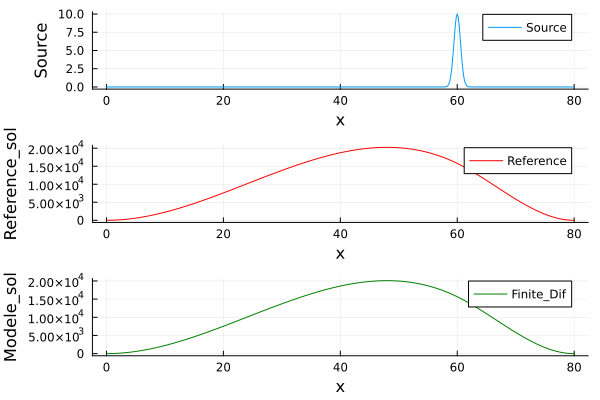

In [41]:

xvec = Vector(0:dx:l)
fvec = source_function.(xvec)

p1 = plot(xvec, fvec, label = "Source", xlabel = "x", ylabel = "Source")

p2 = plot(xvec, set_boundarys(N), label = "Reference", xlabel = "x", ylabel = "Reference_sol", linecolor = :red)

p3 = plot(xvec, biharmonic(N), label = "Finite_Dif", xlabel = "x", ylabel = "Modele_sol", linecolor = :green)

plot(p1, p2, p3, layout = (3, 1))

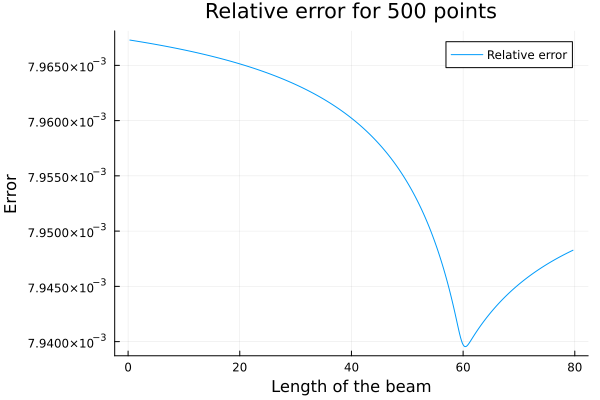

In [42]:

exact = set_boundarys(N)
modele = biharmonic(N)
error = (abs.(exact .- modele) ./ exact) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam", ylabel = "Error", title = title)
